<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/issue/troubleshooting01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install

In [1]:
!git clone https://github.com/skywalker0803r/c620.git
!pip install autorch > log.txt

fatal: destination path 'c620' already exists and is not an empty directory.


# import 

In [2]:
from c620.F import F
from c620.config import config
import joblib
import numpy as np
import pandas as pd
import os
os.chdir('/content/c620')
print(os.getcwd())
!git pull

/content/c620
Already up to date.


# demo data

In [3]:
tag = 'test001'
demo = joblib.load('./data/demo.pkl')
print(demo.keys())

dict_keys(['icg_input', 'c620_feed', 't651_feed', 'c620_op', 'c620_wt', 'c660_op', 'c660_wt', 'c670_op', 'c670_wt'])


In [4]:
icg_input = demo['icg_input']
c620_feed = demo['c620_feed']
t651_feed = demo['t651_feed']

In [5]:
icg_input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
124-020,163.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,72.0,0.0911,20.854397,74.689774,70.0,980.0,0.01,9.999955,36.0


# 問題 : 試算模式 跟操作模式 給出的 op 一模一樣

In [6]:
f = F(config)
f.Recommended_mode = False #(True or False)
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,173.129486,178.742218


In [7]:
f = F(config)
f.Recommended_mode = True #(True or False)
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

current Distillate Rate_m3/hr:0.19312750500839015 NA in Benzene_ppmw:980.0


,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,173.129486,178.742218


一種可能的原因是上面那一組樣本的問題
* 1.NA in Benzene_ppmw = 980.0 
* 2.Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt% = 70 

恰巧等於推薦模式下的初始值,造成推薦模式並沒有做額外的工作

# 解法1

嘗試修改輸入樣本

In [8]:
icg_input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'] = 980*0.5
icg_input['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%'] = 70*0.5
icg_input

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
124-020,163.0,1.116023,11.152225,48.745979,15.0,2.338977,74.302254,17.467825,72.0,0.0911,20.854397,74.689774,35.0,490.0,0.01,9.999955,36.0


In [9]:
f = F(config)
f.Recommended_mode = False #(True or False)
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,173.129486,178.745392


In [10]:
f = F(config)
f.Recommended_mode = True #(True or False)
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed)
c620_op.filter(regex='Temp')

current Distillate Rate_m3/hr:0.19312750500839015 NA in Benzene_ppmw:980.0


,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
124-020,173.129486,178.742218


看來不是樣本的問題

# 解法2

觀察 改動 icg_input 如何影響 wt op 

In [11]:
f = F(config)
f.Recommended_mode = False
icg_input = demo['icg_input']
logger = {}
from tqdm import tqdm_notebook as tqdm
for c in tqdm(icg_input.columns):
  logger[c] = {}
  init_value = icg_input[c].values[0]
  for m in tqdm(np.arange(0.5,2.0,0.1)):
    icg_input[c] = init_value*m # change input
    c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f(icg_input,c620_feed,t651_feed) # get output
    logger[c][init_value*m] = c620_wt.join(c620_op) # record

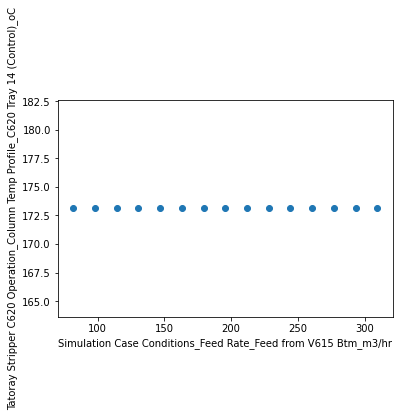

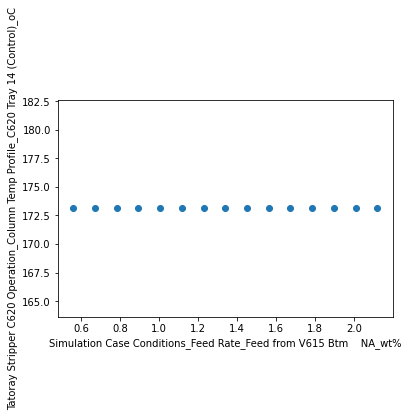

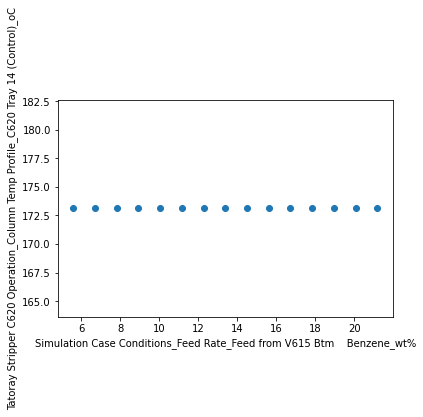

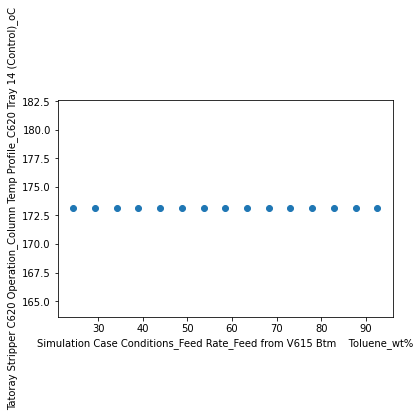

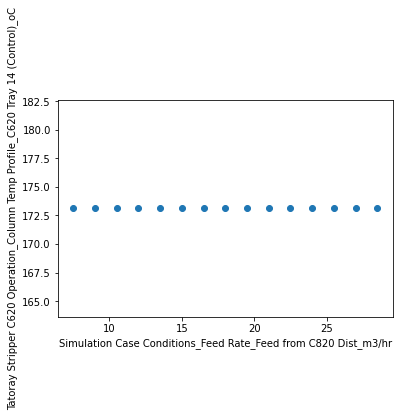

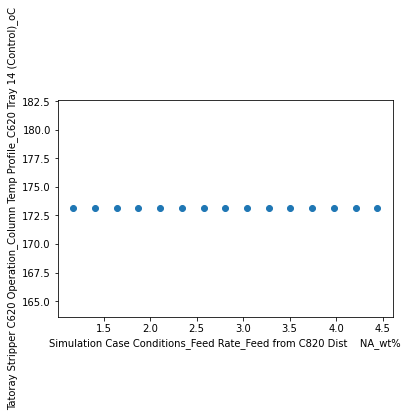

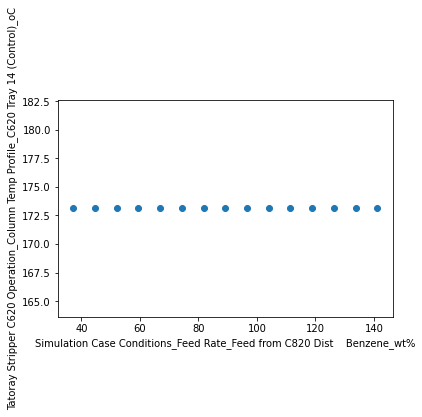

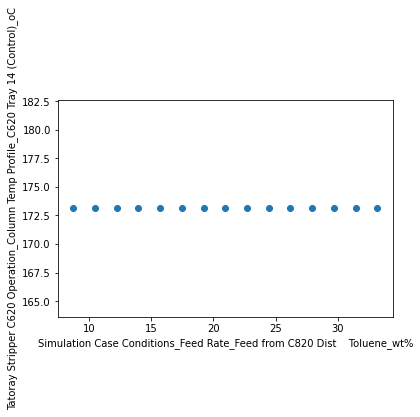

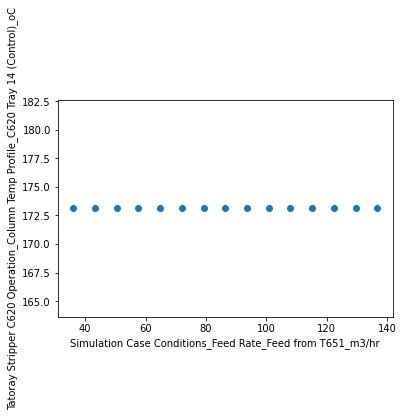

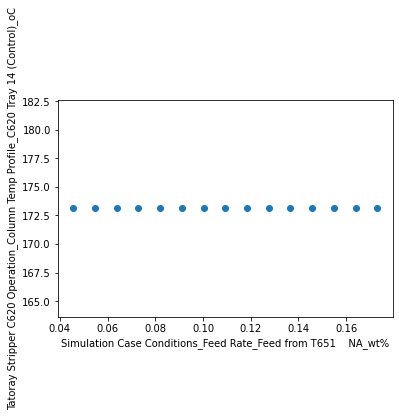

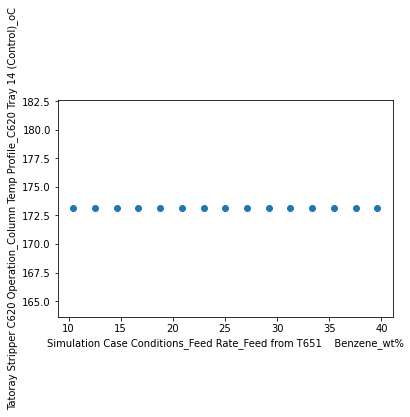

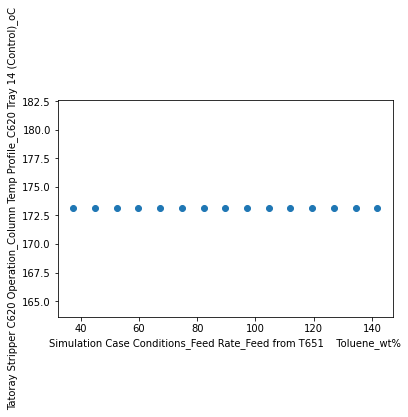

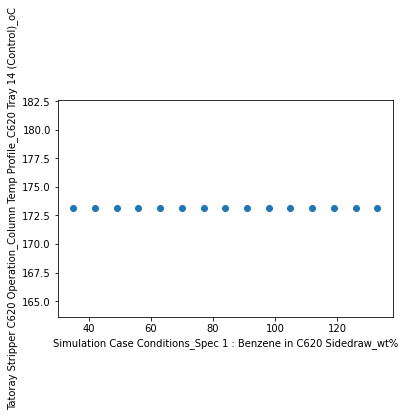

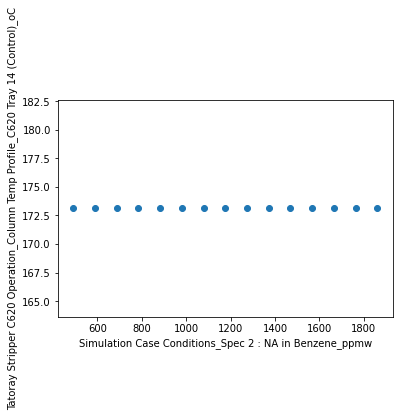

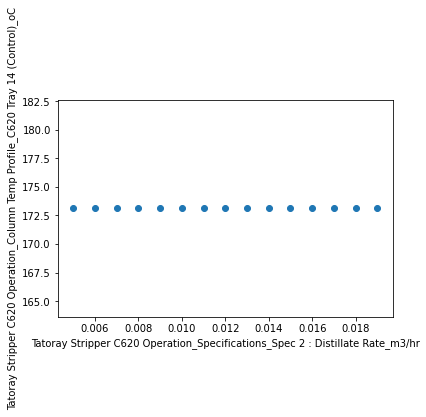

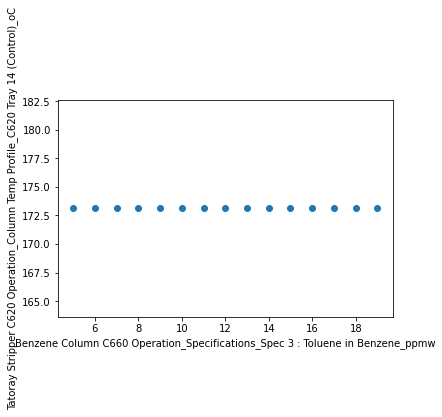

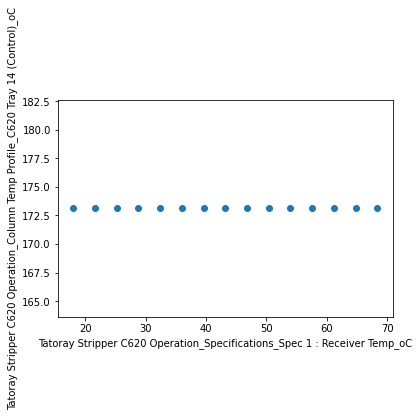

In [12]:
import matplotlib.pyplot as plt

for i in logger.keys():
  x = logger[i].keys()
  y = [logger[i][j]['Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC'].values[0] for j in logger[i].keys()]
  plt.scatter(x,y)
  plt.xlabel(i)
  plt.ylabel('Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC')
  plt.show()

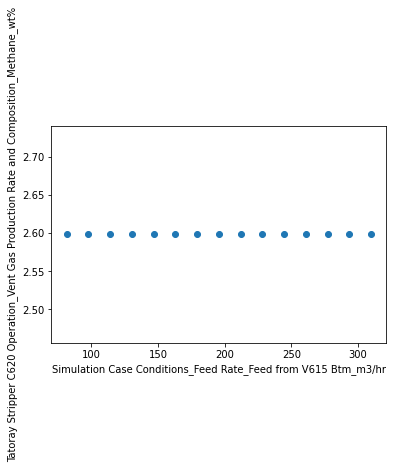

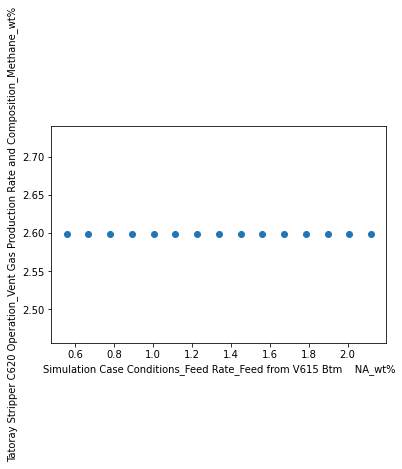

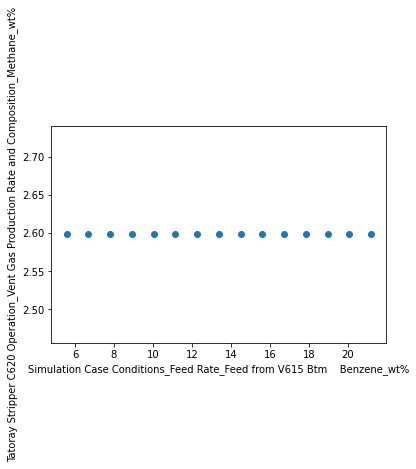

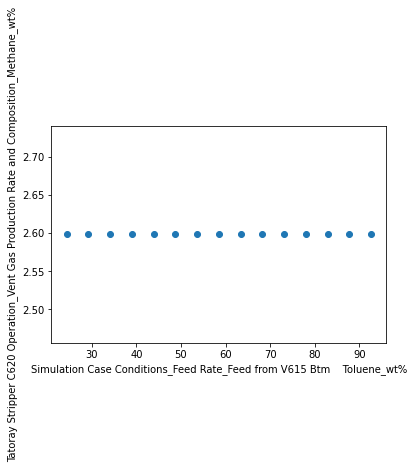

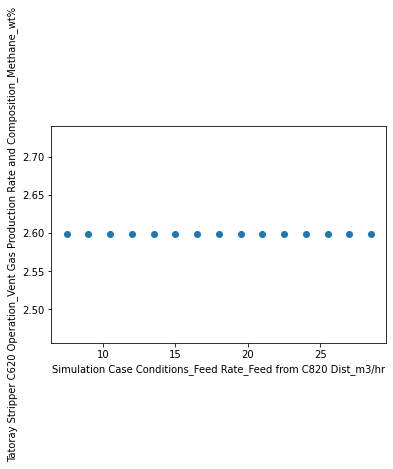

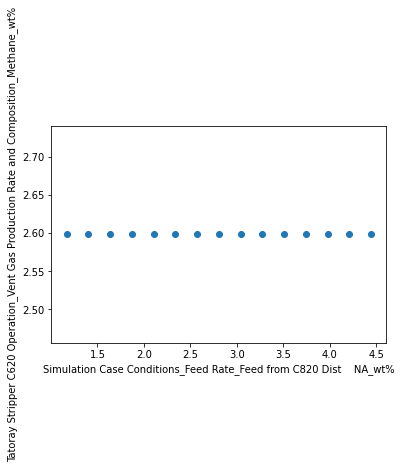

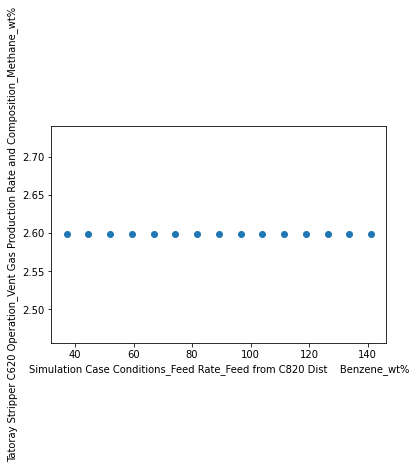

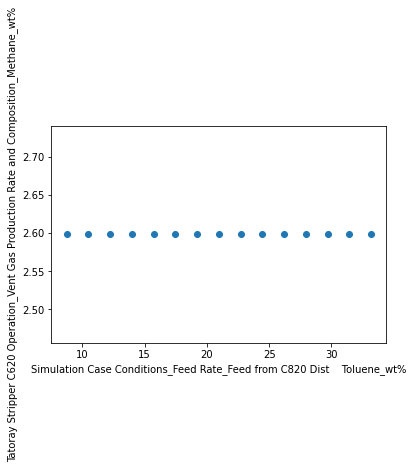

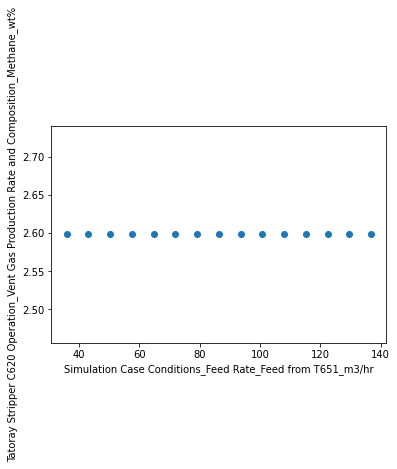

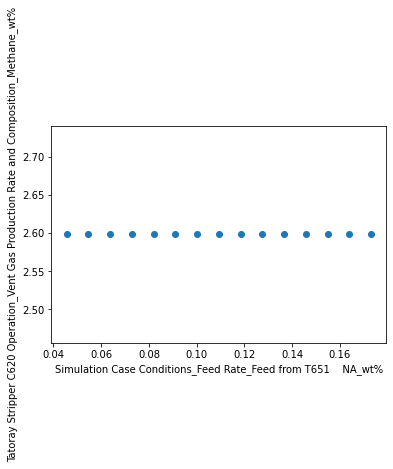

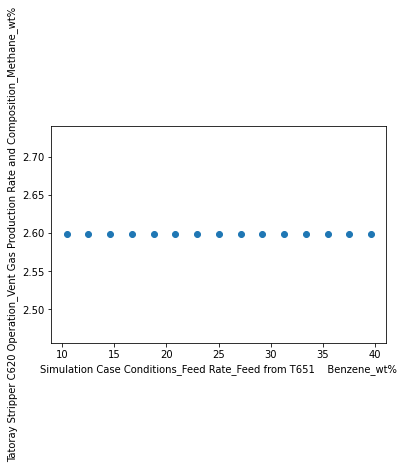

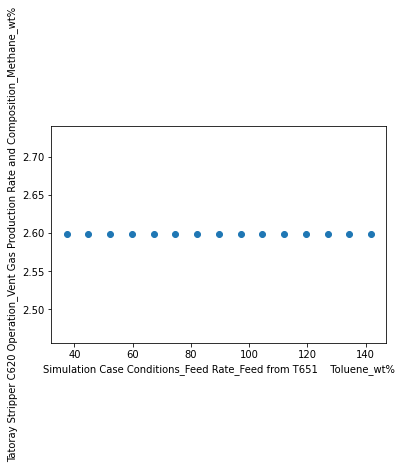

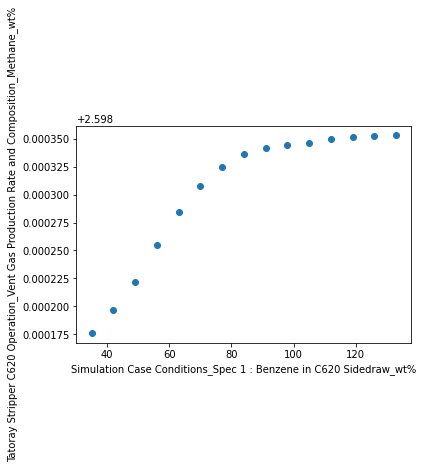

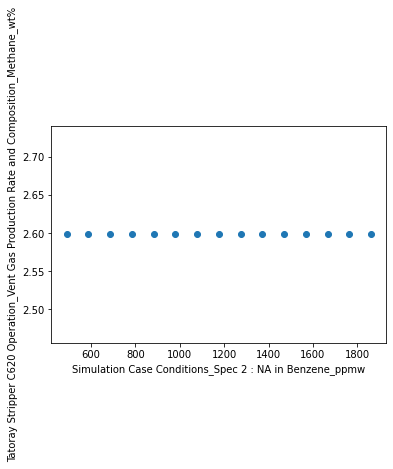

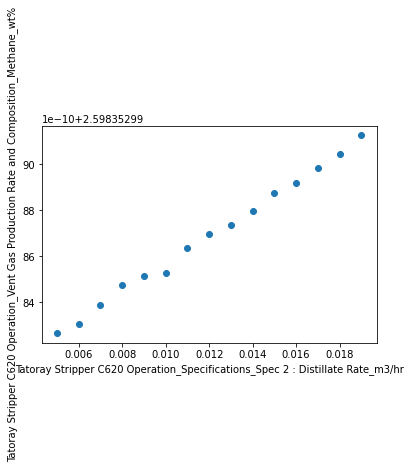

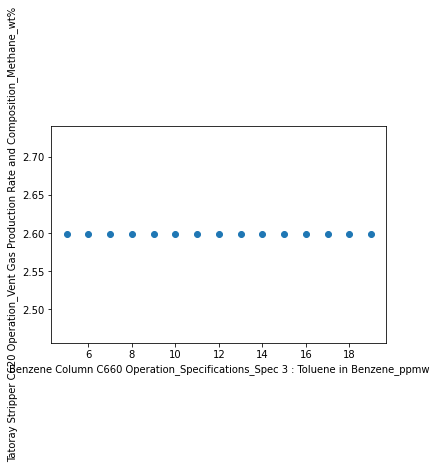

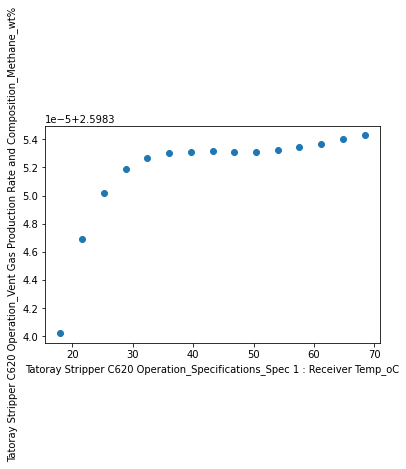

In [13]:
for i in logger.keys():
  x = logger[i].keys()
  y = [logger[i][j]['Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%'].values[0] for j in logger[i].keys()]
  plt.scatter(x,y)
  plt.xlabel(i)
  plt.ylabel('Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%')
  plt.show()

# 觀察得出調整icg_input 某些值 會對 c620_wt 造成影響 但確幾乎不會對c620_op造成影響

以下實際 load 模擬數據來觀察

In [14]:
icg_data = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_c670.csv',index_col=0)
c620_data = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0).loc[icg_data.index]
c660_data = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0).loc[icg_data.index,
                                                                                                          ['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]
df = icg_data.join(c620_data).join(c660_data)
df.head()

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Simulation Case Conditions_C620 Distillate Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Toluene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Octane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Propylcyclopentane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for 

In [15]:
df[icg_input.columns.tolist()+c620_op.columns.tolist()].corr().abs().loc[icg_input.columns.tolist(),
                                                                         ['Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC']].style.background_gradient()

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC
Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,0.133641
Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,0.119161
Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,0.119153
Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,0.119150
Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,nan
Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,0.011523
Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,0.000000
Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,0.000000
Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,0.002344
Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,0.000087


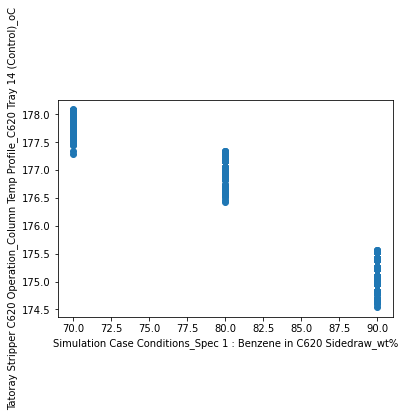

In [16]:
plt.scatter(df['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%'],df['Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC'])
plt.xlabel('Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%')
plt.ylabel('Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC')
plt.show()

以下實際 load 現場數據來觀察

In [17]:
icg_data = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/icg_data.xlsx',index_col=0)
c620_data = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0).loc[icg_data.index]
c660_data = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c660_data.xlsx',index_col=0).loc[icg_data.index,
                                                                                                                      ['Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw']]
df = icg_data.join(c620_data).join(c660_data)
df.head()

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Simulation Case Conditions_C620 Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Toluene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Octane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Propylcyclopentane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Ethylcyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Ethylbenzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_p-Xylene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_m-Xylene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_o-Xylene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Fact

In [18]:
df[icg_input.columns.tolist()+c620_op.columns.tolist()].corr().abs().loc[icg_input.columns.tolist(),
                                                                         ['Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC']].style.background_gradient()

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC
Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,0.176490
Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,0.173060
Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,0.389031
Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,0.467188
Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,0.157744
Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,0.190414
Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,0.088481
Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,0.235594
Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,0.002389
Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,0.447853


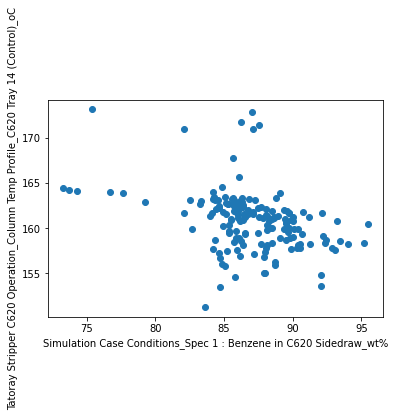

In [19]:
plt.scatter(df['Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%'],df['Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC'])
plt.xlabel('Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%')
plt.ylabel('Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC')
plt.show()